/tmp/ipykernel_170107/3829396820.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Attempting to download AAPL data...
Download successful.



/home/navit/DAV_LAB/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2558/2558 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 4.6120e-04
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Root Mean Squared Error: 4.4281
Mean Absolute Error: 3.5640


/tmp/ipykernel_170107/3829396820.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


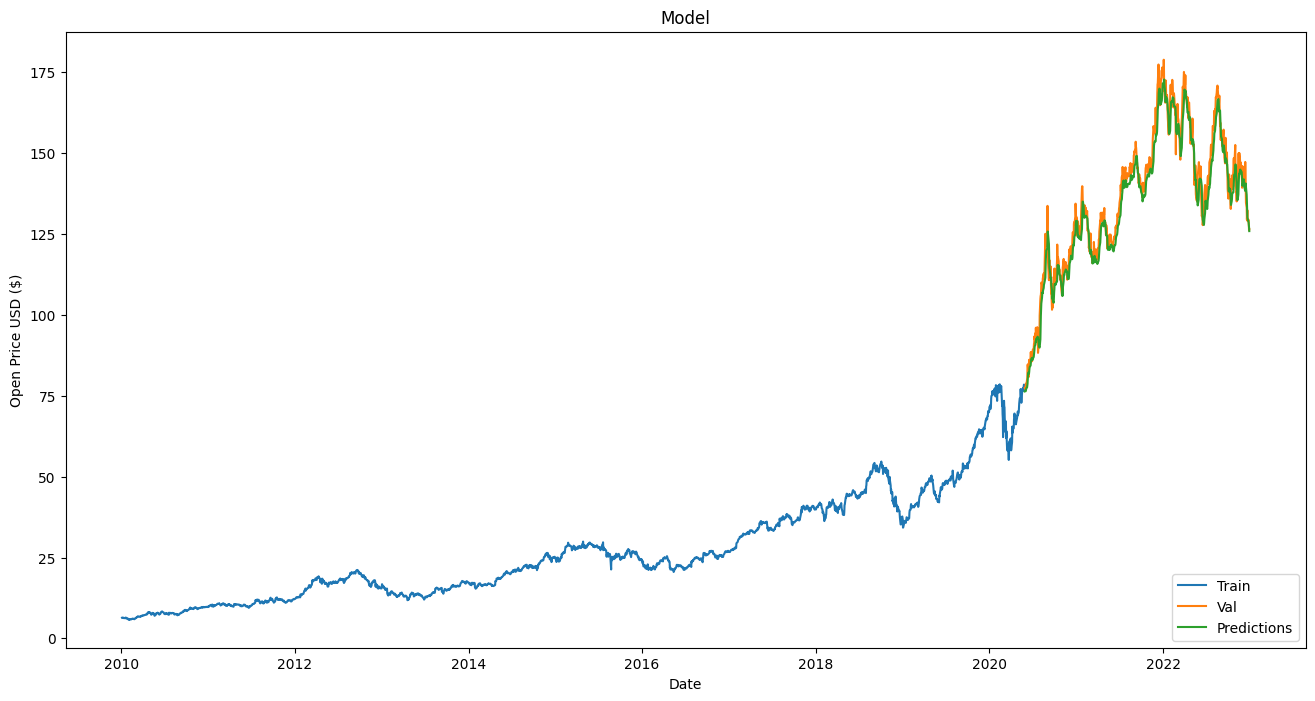

                  Open  Predictions
Date                               
2020-05-29   77.420245    76.337646
2020-06-01   77.056502    76.405739
2020-06-02   77.784018    76.391762
2020-06-03   78.732222    76.575150
2020-06-04   78.666747    77.029831
...                ...          ...
2022-12-23  128.974252   129.736206
2022-12-27  129.427431   128.714417
2022-12-28  127.742826   127.993927
2022-12-29  126.087797   127.075226
2022-12-30  126.501579   125.902840

[654 rows x 2 columns]


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

def fetch_stock_data(ticker, start_date, end_date):
        print(f"Attempting to download {ticker} data...")
        data = yf.download(ticker, start=start_date, end=end_date)
        if data.empty:
            raise ValueError("Downloaded data is empty.")
        
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)
            
        print("Download successful.")
        return data


ticker = 'AAPL'
data = fetch_stock_data(ticker, start_date='2010-01-01', end_date='2023-01-01')

if 'Date' in data.columns:
    data = data.sort_values('Date')
    
# Ensure we have the 'Open' column
if 'Open' not in data.columns:
    # Fallback to the first column if 'Open' is missing but data exists
    print("Column 'Open' not found. Using the first column available.")
    data = data.iloc[:, [0]]
    data.columns = ['Open']
else:
    data = data.filter(['Open'])

dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .8))

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse:.4f}')

mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae:.4f}')

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Open Price USD ($)')
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

print(valid)